In [53]:
import pandas as pd
import os
import seaborn as sns
import numpy as np 

import emoji
import spacy



def get_token_word_count(token_list):
    """
    gets tokens word_counts
    """
    
    count = 0
    for token in token_list:
        not_word = token.like_url or token.like_num or token.is_oov or token.is_digit or token.is_punct
        if not_word:
            continue
        else:
            count+=1
    return count

def clean_tokens(token_list):
    """
    cleans tokens
    """
    
    return [token for token in token_list if not (token.like_url or token.like_num or token.is_oov or token.is_digit or token.is_punct)]

def char_is_emoji(character):
    return character in emoji.EMOJI_DATA


def text_has_emoji(text):
    for character in text:
        if character in emoji.EMOJI_DATA:
            return True
    return False

def find_ngrams(input_list, n):
    grams = [i for i in zip(*[input_list[i:] for i in range(n)])]
    return Counter(grams)

In [22]:

nlp = spacy.load("es_core_news_lg")

In [23]:
data_loc = "../master_data/DATA.csv"
df = pd.read_csv(data_loc)

El Dataset contiene 11717 observaciones, con 4 variables cada uno. 

In [24]:
df.shape

(11717, 4)

Las variables

* feature: Contienen el cuerpo de texto. 
* label: Etiqueta, 1 hace referencia a contenido misógino, 0 a no misógino.
* tweet_id: Id del tweet del cual proviene el cuerpo de texto. Pertinente para los datos obtenidos a a partir de la base de datos misocorpus
* origin: base de datos de la cual proviene la observación. (rnn -> base RNN, miso -> misocorpus)
    

In [25]:
df.dtypes

feature      object
label         int64
tweet_id    float64
origin       object
dtype: object

A preview of the dataset

In [26]:
df.head()

,feature,label,tweet_id,origin
0,es sexy.,1,NaN,rnn
1,eres mía.,1,NaN,rnn
2,la gorda.,1,NaN,rnn
3,a fregar.,1,NaN,rnn
4,ca- gona.,1,NaN,rnn


Limpieza

* homologación del texto a minúsculas. 
* Se eliminaron el espacio antes y despues de cada texto.
* Se eliminó el punto al final de una oración.
* Se eliminaron los caracteres literales de salto de linea 
* Se eliminan las tildes no balanceadas. "
* Se sustituyó q for "que"
* Se sustituyó d for "de"
* Se etiquetaron las etiquetas con las clases misogino 1 no misogino 0
* Se etiquetaron las observaciones que continen urls.
* Se crearon los tokens de spacy para facilitar el procesamiento y limpieza posterior.

In [27]:


df.loc[:,["feature"]] = df.feature.str.lower()
df.loc[:,["feature"]] = df.feature.str.replace("\.$","",regex=True).\
str.replace("[\\n]+"," ",regex=True).\
str.replace("\"","").\
str.replace("\s*q ","que ",regex=True).\
str.replace(" d ","de").\
str.strip()
df.loc[:,["clase"]] = df.label.apply(lambda x: "misogino" if x == 1 else "no misogino")
df["has_image"] = df.feature.str.contains("http")
df.loc[:,["tokenized"]] = df.feature.apply(lambda x: [token for token in nlp(x)])


A continuación, con la ayuda del código en el módulo helpers,
se procesarán las observaciones mediante dos funciones para obtener lo siguente. 
1. Agregar la cuenta de palabras ("word count"), tomando en cuenta solo palabras que formen parte del vocabulario.
2. Limpieza de las palabras tokens, así como agregarlos a una columna con tipo lista. "clean tokens"
La limpieza de los tokens comprende:
* eliminar las urls.
* eliminar los números.
* eliminar palabras/tokens fuera del vocabulario. 
* eliminar los digitos. 
* elimanar puntuación. 

In [28]:

df["word_count"] =df.tokenized.apply(get_token_word_count)
df["clean_tokens"] = df.tokenized.apply(clean_tokens)

Una vez aplicado el procesamiento y la limpieza, la base de datos tiene la siguiente forma: 

In [31]:
df.head()

,feature,label,tweet_id,origin,clase,has_image,tokenized,word_count,clean_tokens
0,es sexy,1,NaN,rnn,misogino,False,"[es, sexy]",2,"[es, sexy]"
1,eres mía,1,NaN,rnn,misogino,False,"[eres, mía]",2,"[eres, mía]"
2,la gorda,1,NaN,rnn,misogino,False,"[la, gorda]",2,"[la, gorda]"
3,a fregar,1,NaN,rnn,misogino,False,"[a, fregar]",2,"[a, fregar]"
4,ca- gona,1,NaN,rnn,misogino,False,"[ca-, gona]",2,"[ca-, gona]"


In [32]:
df.clase.value_counts().to_frame()

,count
clase,
misogino,8689
no misogino,3028


Histograma con la distribución del numero de palabras por feature.

<Axes: xlabel='word_count', ylabel='Count'>

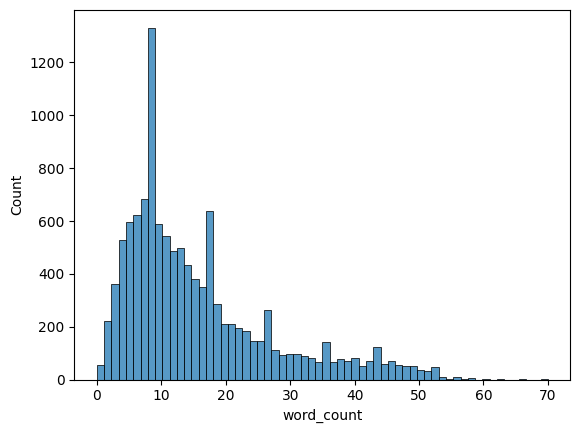

In [33]:
sns.histplot(data=df, x="word_count")

Veamos la distribución separando por clases.
En la gráfica inferior se puede observar que el número de palabras en el cuerpo
de texto no es una característica que distinga un texto misógino de uno no misógino. 
Asimismo, se confirma que la muestra de datos no esta balanceada, pues hay más datos
misóginos que no misóginos. 

<Axes: xlabel='word_count', ylabel='Count'>

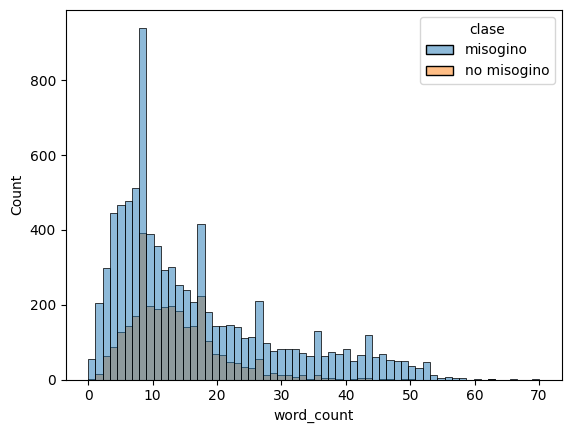

In [34]:

sns.histplot(data=df, x="word_count",hue="clase")

Análisis de frecuencia de palabras.

In [56]:
from collections import defaultdict, Counter
sentences = df.clean_tokens.values.tolist()
corpus_tokens = [token for i in sentences for token in i if not token.is_stop and not token.is_oov and not text_has_emoji(token.text)]
# create tokendict token_Text -> token
token_dict = {token.text:token for token in set(corpus_tokens)}
# create the corpus 
corpus = list(map(lambda token: token.text, corpus_tokens))
# # corpus = [text for text,token in corpus_tokens.items()]
count_dict=Counter(corpus)
# # create dataframe with count_dict
freq_df = pd.DataFrame.from_dict(count_dict,orient='index').reset_index(names=["word"])
freq_df.columns = ["word","freq"]
most_freq_emoji = freq_df.sort_values("freq",ascending=False).head(60)
#filter out emoji
most_freq = freq_df.loc[np.logical_not(freq_df.word.apply(text_has_emoji))].sort_values("freq",ascending=False)

Tabla de palabras por frecuencia

In [57]:
most_freq.head(20)

,word,freq
18,mujer,1238
27,puta,786
54,mujeres,775
3081,feminazi,596
3312,feminazis,541
107,hombre,483
8466,arandina,453
153,hombres,411
763,años,367
570,vida,328


Gráfica de barras con las palabras más usadas

<Axes: xlabel='freq', ylabel='word'>

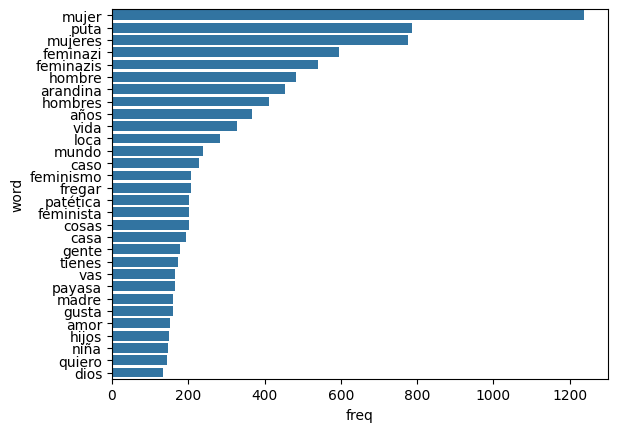

In [55]:
sns.barplot(data= most_freq.head(30),x="freq",y="word")

Tabla de bigramas más usados

In [21]:
bigrams_df = pd.DataFrame.from_dict(find_ngrams(corpus,2), orient='index').reset_index().rename(columns={"index":"bigram",0:"freq"})
bigrams_df\
.loc[bigrams_df.bigram.apply(lambda x: False if "arandina" in x else True)]\
.sort_values("freq",ascending=False).head(20)

,bigram,freq
33819,"(puta, idea)",67
64,"(hija, puta)",58
94,"(puta, madre)",55
25968,"(años, cárcel)",42
46,"(hijo, puta)",41
396,"(mujer, mujer)",39
31549,"(cumbre, clima)",35
1158,"(hombre, mujer)",32
33571,"(hijos, puta)",31
25990,"(🇪, 🇸)",31


Tabla de trigramas más usados

In [22]:

trigrams_df = pd.DataFrame.from_dict(find_ngrams(corpus,3), orient='index').reset_index().rename(columns={"index":"trigram",0:"freq"})
trigrams_df\
.loc[trigrams_df.trigram.apply(lambda x: False if "arandina" in x else True)]\
.sort_values("freq",ascending=False).head(20)


,trigram,freq
28184,"(🇪, 🇸, 🇪)",24
28185,"(🇸, 🇪, 🇸)",24
37331,"(tienes, puta, idea)",23
30402,"(🇦, 🇷, 🇦)",18
30403,"(🇷, 🇦, 🇷)",18
1551,"(gusta, den, duro)",17
32803,"(️, ️, ️)",14
51041,"(agresión, sexual, menor)",12
10662,"(pinche, vieja, interesada)",12
10517,"(encanta, panocha, tetas)",11


In [77]:

from wordcloud import WordCloud
# Read the whole text.
text = " ".join(corpus)
# Generate a word cloud image
wordcloud = WordCloud().generate(text)
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(text),max_font_size=40, relative_scaling=.5).generate(text)

El Dataset contiene 11717 observaciones, with 4 columnas cada uno. 

Nube de palabras más frecuente

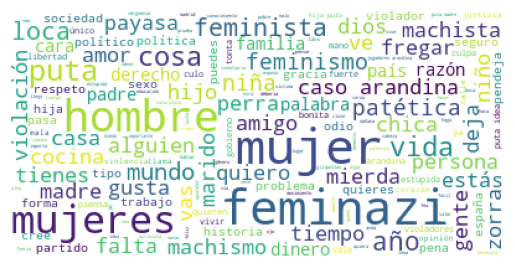